In [ ]:
#| default_exp diet_plots

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import List, Tuple

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.patches as Patch

In [ ]:
#| export
from pheno_utils.timeseries_plots import format_timeseries, format_xticks, plot_events_bars
from pheno_utils.config import DEFAULT_PALETTE, LEGEND_SHIFT


def plot_nutrient_bars(
    diet_log: pd.DataFrame, 
    x: str='collection_timestamp',
    label: str='short_food_name',
    participant_id: int=None, 
    array_index: int = None,
    time_range: Tuple[str, str]=None, 
    meals: bool=True,
    summary: bool=False,
    nut_include: List[str]=None,
    nut_exclude: List[str]=None,
    agg_units: dict={'kcal': 'sum', 'g': 'sum', 'mg': 'sum'},
    legend: bool=True,
    bar_width=np.timedelta64(15, 'm'),
    palette: str=DEFAULT_PALETTE,
    alpha: float=0.7,
    ax: plt.Axes=None,
    figsize: Tuple[float, float]=(14, 3),
):
    """
    Plot a stacked bar chart representing nutrient intake for each meal over time.

    Args:
        diet_log (pd.DataFrame): The dataframe containing the diet log data, with columns for timestamps, nutrients, and other measurements.
        x (str): The name of the column in `diet_log` representing the x-axis variable, such as timestamps. Default is 'collection_timestamp'.
        label (str): The name of the column in `diet_log` representing the labels for each meal. Default is 'short_food_name'.
        participant_id (Optional[int]): The participant's ID to filter the diet log. If None, no filtering is done. Default is None.
        array_index (Optional[int]): The array index to filter the diet log. If None, no filtering is done. Default is None.
        time_range (Optional[Tuple[str, str]]): A tuple of strings representing the start and end dates for filtering the data. Format should be 'YYYY-MM-DD'. Default is None.
        meals (bool): If True, includes individual meals in the plot. Default is True.
        summary (bool): If True, includes a daily summary in the plot. Default is False.
        nut_include (List[str]): A list of nutrients to include in the plot. Default is None.
        nut_exclude (List[str]): A list of nutrients to exclude from the plot. Default is None.
        agg_units (dict): A dictionary mapping nutrient units to aggregation functions. Only nutrients with units in this dictionary are plotted.
        legend (bool): If True, includes a legend in the plot. Default is True.
        bar_width (np.timedelta64): The width of the bars representing each meal on the time axis. Default is 15 minutes.
        palette (str): The color palette to use for the stacked bars.
        alpha (float): The transparency of the stacked bars. Default is 0.7.
        ax (Optional[plt.Axes]): The Matplotlib axis on which to plot the bar chart. If None, a new axis is created. Default is None.
        figsize (Tuple[float, float]): The size of the figure to create. Default is (14, 3).

    Returns:
        None: The function creates a stacked bar chart on the specified or newly created axis.
    """
    # Prepare the data for plotting
    df, grouped_nutrients = prepare_meals(
        diet_log,
        participant_id=participant_id,
        array_index=array_index,
        time_range=time_range,
        label=label,
        return_meals=meals,
        return_summary=summary,
        y_include=nut_include,
        y_exclude=nut_exclude,
        agg_units=agg_units,
        x_col=x,
        )

    if ax is None:
        fig, ax = plt.subplots(
            len(grouped_nutrients), 1,
            figsize=(figsize[0], figsize[1] * len(grouped_nutrients)),
            sharex=True)
        if len(grouped_nutrients) == 1:
            ax = [ax]

    colors = sns.color_palette(
        palette, sum([len(g) for g in grouped_nutrients.values()]))

    # Calculate the width in time units
    bar_width_in_days = bar_width / np.timedelta64(1, 'D')

    unit_list = [g for g in grouped_nutrients if g != 'kcal']
    if 'kcal' in grouped_nutrients:
        # kcal is last to keep colours synced with the lollipop plot
        unit_list.append('kcal')

    # Stacked bar plots for grouped nutrients
    c = 0
    for idx, unit in enumerate(unit_list):
        bottom = pd.Series([0] * len(df))
        for nut in grouped_nutrients[unit]:
            if nut in ['weight_g']:
                continue
            ax[idx].bar(
                df[x], df[nut], bottom=bottom, width=bar_width_in_days,
                color=colors[c], alpha=alpha, label=nut)
            bottom += df[nut]
            c += 1
        ax[idx].set_ylabel(f'Nutrients ({unit})', rotation=0, horizontalalignment='right')
        if legend:
            ax[idx].legend(loc='upper left', bbox_to_anchor=LEGEND_SHIFT)
        ax[idx].grid(True)

    # Set x-tick labels for the bottom and top axes
    format_xticks(ax[-1], df[x])
    if label is not None:
        secax = ax[0].secondary_xaxis('top')
        secax.set_xticks(df[x])
        secax.set_xticklabels(df[label], ha='center', fontsize=9)

    return ax


def plot_nutrient_lollipop(
    diet_log: pd.DataFrame, 
    x: str='collection_timestamp',
    y: str='calories_kcal',
    size: str='total_g', 
    label: str='short_food_name',
    participant_id: int=None, 
    array_index: int=None,
    time_range: Tuple[str, str]=None, 
    meals: bool=True,
    summary: bool=False,
    nut_include: List[str]=None,
    nut_exclude: List[str]=None,
    legend: bool=True,
    size_scale: float=5,
    palette: str=DEFAULT_PALETTE,
    alpha: float=0.7,
    ax: plt.Axes=None,
    figsize: Tuple[float, float] = (12, 3),
):
    """
    Plot a lollipop chart with pie charts representing nutrient composition for each meal.

    NOTE: The y-axis is scaled to match the units of the x-axis, to avoid distortion of the pie charts.
    Due to scaling, if you intend to change `xlim` after plotting, you must also provide `date_range`.
    Use the `second_y` of g.plot() option to plot it with other y-axis data.

    Args:
        diet_log (pd.DataFrame): The dataframe containing the diet log data, with columns for timestamps, nutrients, and other measurements.
        x (str): The name of the column in `diet_log` representing the x-axis variable, such as timestamps. Default is 'collection_timestamp'.
        y (str): The name of the column in `diet_log` representing the y-axis variable, such as calories. Default is 'calories_kcal'.
        size (str): The name of the column in `diet_log` representing the size of the pie charts. Default is 'total_g'.
        label (str): The name of the column in `diet_log` representing the labels for each meal. Default is 'short_food_name'.
        participant_id (Optional[int]): The participant's ID to filter the diet log. If None, no filtering is done. Default is None.
        time_range (Optional[Tuple[str, str]]): A tuple of strings representing the start and end dates for filtering the data. Format should be 'YYYY-MM-DD'. Default is None.
        meals (bool): If True, includes individual meals in the plot. Default is True.
        summary (bool): If True, includes a daily summary in the plot. Default is False.
        nut_include (List[str]): A list of nutrients to include in the plot. Default is None.
        nut_exclude (List[str]): A list of nutrients to exclude from the plot. Default is None.
        legend (bool): If True, includes a legend in the plot. Default is True.
        size_scale (float): The scaling factor for the size of the pie charts. Default is 5.
        palette (str): The color palette to use for the pie slices. Default is DEFAULT_PALETTTE.
        alpha (float): The transparency of the pie slices. Default is 0.7.
        ax (Optional[plt.Axes]): The Matplotlib axis on which to plot the lollipop chart. If None, a new axis is created. Default is None.
        figsize (Tuple[float, float]): The size of the figure to create. Default is (12, 6).

    Returns:
        None: The function creates a lollipop plot with pie charts on the specified or newly created axis.
    """
    # Prepare the data for plotting
    df, grouped_nutrients = prepare_meals(
        diet_log,
        participant_id=participant_id,
        array_index=array_index,
        time_range=time_range,
        return_meals=meals,
        return_summary=summary,
        y_include=nut_include,
        y_exclude=nut_exclude,
        x_col=x,
        )

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    # Convert nutrients in mg to grams
    for nut in grouped_nutrients['mg']:
        df[nut.replace('_mg', '_g')] = df[nut] / 1000
        grouped_nutrients['g'] += [nut.replace('_mg', '_g')]

    pie_nuts = [nut for nut in grouped_nutrients['g']
                if nut not in ['weight_g']]
    df['total_g'] = df[pie_nuts].sum(axis=1)

    # Calculate unknown component and ensure all values are non-negative
    df['other_g'] = (df['weight_g'] - df[pie_nuts].sum(axis=1)).clip(lower=0)
    # pie_nuts += ['other_g']

    # Pre-set the x-axis limits based on the range of timestamps
    if time_range is None:
        min_x = mdates.date2num(df[x].min())
        max_x = mdates.date2num(df[x].max())
    else:
        min_x = mdates.date2num(pd.to_datetime(time_range[0]))
        max_x = mdates.date2num(pd.to_datetime(time_range[1]))

    # Pre-set the y-axis limits based on the range of the y-axis column
    min_y = 0  # df[y_col].min()
    max_y = df[y].max()

    # Calculate the aspect ratio between the x and y axes
    # This is necessary to avoid distortion of the (circular) pie charts
    x_range = max_x - min_x
    y_range = max_y - min_y
    aspect_ratio = x_range / y_range
    y_delta = 0.1 * y_range

    # Scale the y-axis to match the aspect ratio of the x-axis
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y * aspect_ratio, (max_y + y_delta) * aspect_ratio)

    # Custom formatter to adjust the y-ticks back to the original scale
    def ytick_formatter(y, pos):
        return f'{y / aspect_ratio:.0f}'

    # Plotting the lollipop plot with pies using absolute figure coordinates
    for idx, row in df.iterrows():
        # Pie chart parameters
        size_value = np.sqrt(row[size]) * aspect_ratio * size_scale
        position = mdates.date2num(row[x])
        y_value = row[y] * aspect_ratio  # Scale y-value

        # Plot the stem (lollipop stick)
        ax.plot([position, position], [0, y_value], color='gray', lw=1, zorder=1)

        # Plot the pie chart in figure coordinates (no distortion)
        wedges = draw_pie_chart(ax, position, y_value, row[pie_nuts].fillna(0.).values, size_value, palette, alpha)

    if legend:
        # Create a custom legend
        ax.legend(handles=wedges, labels= pie_nuts, loc='upper left', bbox_to_anchor=LEGEND_SHIFT)

    # Format x-axis to display dates properly
    ax.set_ylabel(y.replace('_', ' ').title(), rotation=0, horizontalalignment='right')
    ax.grid(True)

    # Set y-ticks and x-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(ytick_formatter))
    ylim = ax.get_ylim()
    yticks = np.arange(0, ylim[1] / aspect_ratio, 100, dtype=int)
    ax.set_yticks(yticks * aspect_ratio)
    ax.set_yticklabels(yticks)

    format_xticks(ax, df[x])
    if label is not None:
        secax = ax.secondary_xaxis('top')
        secax.set_xticks(df[x])
        secax.set_xticklabels(df[label], ha='center', fontsize=9)

    return ax


def prepare_meals(
    diet_log: pd.DataFrame,
    participant_id: int=None,
    array_index: int=None,
    time_range: Tuple[str, str]=None,
    label: str='short_food_name',
    return_meals: bool = True,
    return_summary: bool = False,
    y_include: List[str] = None,
    y_exclude: List[str] = None,
    agg_units: dict={'kcal': 'sum', 'g': 'sum', 'mg': 'sum', 'unknown': 'first'},
    x_col: str='collection_timestamp'
) -> pd.DataFrame:
    """
    Prepare the diet log data for plotting meals and/or daily summaries.

    Args:
        diet_log (pd.DataFrame): The dataframe containing the diet log data, with columns for timestamps, nutrients, and other measurements.
        participant_id (Optional[int]): The participant's ID to filter the diet log. If None, no filtering is done. Default is None.
        array_index (Optional[int]): The array index to filter the diet log. If None, no filtering is done. Default is None.
        time_range (Optional[Tuple[str, str]]): A tuple of strings representing the start and end dates for filtering the data. Format should be 'YYYY-MM-DD'. Default is None.
        label (str): The name of the column in `diet_log` representing the labels for each meal. Default is 'short_food_name'.
        return_meals (bool): If True, includes individual meals in the plot. Default is True.
        return_summary (bool): If True, includes a daily summary in the plot. Default is False.
        y_include (List[str]): A list of nutrients (regex) to include in the plot. Default is None.
        y_exclude (List[str]): A list of nutrients (regex) to exclude from the plot. Default is None.
        agg_units (dict): A dictionary mapping nutrient units to aggregation functions.
        x_col (str): The name of the column in `diet_log` representing the x-axis variable, such as timestamps. Default is 'collection_timestamp'.

    Returns:
        pd.DataFrame: A dataframe containing the prepared data for plotting.
    """
    diet_log = format_timeseries(
        diet_log, participant_id, array_index, time_range,
        x_start=x_col, x_end=x_col, unique=True)

    units = extract_units(diet_log.columns)
    grouped_nutrients = {}
    import re  # Add this line to import the re module

    agg_dict = {}
    for nut, unit in units.items():
        if unit not in agg_units:
            continue
        if y_include is not None and not any([re.match(inc, nut) for inc in y_include]):
            continue
        if y_exclude is not None and any([re.match(exc, nut) for exc in y_exclude]):
            continue
        if unit not in grouped_nutrients:
            grouped_nutrients[unit] = []
        grouped_nutrients[unit].append(nut)
        agg_dict[nut] = agg_units[unit]
    nut_list = list(agg_dict.keys())
    if label is not None:
        agg_dict[label] = lambda x: '\n'.join(x)

    df = diet_log\
        .dropna(subset=['short_food_name'])\
        .drop_duplicates()\
        .groupby([x_col])\
        .agg(agg_dict)\
        .reset_index()

    if return_summary:
        # Add daily summary by grouping by date and summing up the nutrients
        daily_df = df.groupby(df[x_col].dt.date)[nut_list]\
            .sum().reset_index()
        if label is not None:
            daily_df[label] = daily_df[x_col].astype('string') + '\nDaily Summary'
        daily_df[x_col] = pd.to_datetime(daily_df[x_col] + pd.Timedelta(hours=24))
        if time_range is not None:
            daily_df = daily_df[(time_range[0] <= daily_df[x_col]) & (daily_df[x_col] <= time_range[1])]
        if return_meals:
            # God knows why, but the two refuse to concat without this
            df = pd.DataFrame(np.vstack([df, daily_df]), columns=df.columns)
        else:
            df = daily_df

    return df, grouped_nutrients


def extract_units(column_names: List[str]) -> dict:
    units = {}
    for col in column_names:
        if '_' in col:
            unit = col.split('_')[-1]
            units[col] = unit
        else:
            units[col] = 'unknown'
    return units


def draw_pie_chart(
    ax: plt.Axes, 
    x: float, 
    y: float, 
    data: List[float], 
    size: float, 
    palette: str = DEFAULT_PALETTE,
    alpha: float = 0.7,
):
    """
    Draw a pie chart as an inset (in absolute figure coordinates) within the given axes
    at the specified data coordinates.
    What this solves is the issue of y-axis and x-axis scaling being different, which
    distorts the pie chart when drawn directly on the axes.

    Args:
        ax (plt.Axes): The axis on which to draw the pie chart.
        x (float): The x-coordinate in data coordinates where the pie chart's center will be placed.
        y (float): The y-coordinate in data coordinates where the pie chart's center will be placed.
        data (List[float]): The data values to be represented in the pie chart.
        size (float): The size (radius) of the pie chart in axes-relative coordinates.
        palette (str): The color palette to use for the pie slices.

    Returns:
        List[plt.Patch]: A list of wedge objects representing the pie chart slices.
    """
    # Convert the position from data coordinates to axes coordinates
    axes_coords = ax.transData.transform((x, y))
    axes_coords = ax.transAxes.inverted().transform(axes_coords)

    # Create a new inset axis to draw the pie, using axes-relative coordinates
    inset_ax = ax.inset_axes([axes_coords[0] - size, axes_coords[1] - size, 2 * size, 2 * size])

    # Plot the pie chart using the calculated position and scaled radius
    colors = [(r, g, b, alpha) for r, g, b in sns.color_palette(palette, len(data))]
    wedges, _ = inset_ax.pie(data, radius=1, startangle=90, wedgeprops=dict(edgecolor='none'), normalize=True,
                             colors=colors)

    # Hide the axes for the inset (pie chart)
    inset_ax.set_axis_off()

    return wedges


In [ ]:
#| export
SHORT_FOOD_CATEGORIES = {
    'beef, veal, lamb, and other meat products': 'meat products',
    'milk, cream cheese and yogurts': 'milk products',
    'nuts, seeds, and products': 'nuts and seeds',
    'eggs and their products': 'eggs',
    'pulses and products': 'pulses',
    'fruit juices and soft drinks': 'juices and soft drinks',
    'low calories and diet drinks': 'low cal. drinks',
    'poultry and its products': 'poultry',
    'pasta, grains and side dishes': 'grains',
    'industrialized vegetarian food ready to eat': 'industrialized veg.',
}

def plot_meals_hbars(
    diet_log: pd.DataFrame, 
    x: str='collection_timestamp',
    y: str='short_food_category',
    size: str='weight_g', 
    hue: str='short_food_category',
    participant_id: int=None, 
    array_index: int=None,
    time_range: Tuple[str, str]=None, 
    y_include: List[str] = None,
    y_exclude: List[str] = None,
    rename_categories: dict=SHORT_FOOD_CATEGORIES,
    legend: bool=True,
    size_legend: List[int]=[100, 200, 500],
    size_scale: float=5,
    palette: str=DEFAULT_PALETTE,
    alpha: float=0.7,
    ax: plt.Axes=None,
    figsize: Tuple[float, float] = (12, 6),
):
    """
    Plot a diet chart with bars representing meals and their size over time.

    Args:
        diet_log (pd.DataFrame): The dataframe containing the diet log data, with columns for timestamps, nutrients, and other measurements.
        x (str): The name of the column in `diet_log` representing the x-axis variable, such as timestamps. Default is 'collection_timestamp'.
        y (str): The name of the column in `diet_log` representing the y-axis variable, such as food categories. Default is 'short_food_category'.
        size (str): The name of the column in `diet_log` representing the size of the bars. Default is 'weight_g'.
        hue (str): The name of the column in `diet_log` representing the color of the bars. Default is 'short_food_category'.
        participant_id (Optional[int]): The participant's ID to filter the diet log. If None, no filtering is done. Default is None.
        time_range (Optional[Tuple[str, str]]): A tuple of strings representing the start and end dates for filtering the data. Format should be 'YYYY-MM-DD'. Default is None.
        y_include (List[str]): A list of strings representing the categories to include in the plot. Default is None.
        y_exclude (List[str]): A list of strings representing the categories to exclude from the plot. Default is None.
        rename_categories (dict): A dictionary mapping original food categories to shorter names. Default is SHORT_FOOD_CATEGORIES.
        legend (bool): If True, includes a legend in the plot. Default is True.
        size_legend (List[int]): A list of integers representing the sizes to include in the size legend. Default is [100, 200, 500].
        size_scale (float): The scaling factor for the size of the bars. Default is 5.
        palette (str): The palette to use for the bars.
        alpha (float): The transparency of the bars. Default is 0.7.
        ax (Optional[plt.Axes]): The Matplotlib axis on which to plot the lollipop chart. If None, a new axis is created. Default is None.
        figsize (Tuple[float, float]): The size of the figure to create. Default is (12, 6).
    """
    diet_log = format_timeseries(
        diet_log, participant_id, array_index,
        time_range, x_start=x, x_end=x, unique=True)

    diet_log['event_end'] = diet_log[x] \
        + size_scale * pd.to_timedelta(diet_log[size], unit='s')

    # Categories
    diet_log['short_food_category'] = diet_log['food_category'].str.lower()
    for s, t in rename_categories.items():
        diet_log['short_food_category'] = diet_log['short_food_category'].str.replace(s, t, regex=False)
    diet_log['short_food_category'] = diet_log['short_food_category']\
        .str.replace(' and ', ' & ', regex=False)\
        .str.replace('_wholewheat', ' (whole/w)', regex=False)

    # User events plot to plot meals
    ax = plot_events_bars(
        diet_log,
        x_start=x, x_end='event_end',
        y=y, hue=hue,
        y_include=y_include, y_exclude=y_exclude, alpha=alpha,
        ax=ax, figsize=figsize, palette=palette, legend=legend)

    format_xticks(ax, diet_log[x].drop_duplicates())

    add_size_legend(ax, size_legend, size_scale, alpha)

    return ax


def add_size_legend(ax: plt.Axes, sizes: List[int], size_scale: float, alpha: float, shift: int=0):
    """
    Add a size legend to a plot_meals_hbars plot using broken_barh.
    """
    if len(sizes) == 0:
        return

    # Manually add size legend using broken_barh
    sec2day = 1 / (60 * 60 * 24)  # Convert seconds to days
    size_durations = [
        s * size_scale * sec2day
        for s in sizes]
    max_duration = max(size_durations)

    # Calculate the xlim to place the legend bars right at the end
    xlim = ax.get_xlim()  # These are in days
    y_start_legend = ax.get_ylim()[0] - 1 - shift
    x_bar_start = \
        xlim[1] - \
        1.5 * max_duration

    # Add a bounding box around the text and bars
    ax.add_patch(mpatches.Rectangle(
        (x_bar_start - 1.5*(max_duration + 10 * sec2day), y_start_legend - len(sizes) + 0.25),
         3 * (max_duration + 10 * sec2day), len(sizes) + 0.5,
         edgecolor='gray', facecolor='white', lw=1))

    for i, (s, duration) in enumerate(zip(sizes, size_durations)):
        # Plot the bar
        ax.broken_barh(
            xranges=[(x_bar_start, duration)],
            yrange=(y_start_legend - i - 0.4, 0.8), 
            facecolors='gray', alpha=alpha
        )

        # Add text next to the bar
        ax.annotate(f'{s}g', 
                    (x_bar_start - 10 * sec2day, y_start_legend - i),
                    va='center', ha='right', fontsize=10)

In [ ]:
#| export
from pheno_utils.timeseries_plots import TimeSeriesFigure, plot_events_fill
from pheno_utils.sleep_plots import plot_sleep_channels, get_sleep_period

def plot_diet_cgm_sleep(
    diet: pd.DataFrame=None,
    cgm: pd.DataFrame=None,
    sleep_events: pd.DataFrame=None,
    sleep_channels: pd.DataFrame=None,
    cgm_grid: List[int] = [0, 54, 70, 100, 140, 180],
    channel_filter: List[str]=['heart_rate', 'actigraph', 'spo2'],
    participant_id=None,
    array_index=None,
    time_range: Tuple[str, str]=None,
    figsize=(14, 10),
    nutrient_kws: dict={},
    meals_kws: dict={},
    cgm_kws: dict={},
    events_kws: dict={},
    channels_kws: dict={},
) -> TimeSeriesFigure:
    """
    Plot diet, CGM and sleep data together.

    Arg:
        diet (pd.DataFrame): Diet logging data. Set to None to remove from figure.
        cgm (pd.DataFrame): CGM data. Set to None to remove from figure.
        sleep_events (pd.DataFrame): Sleep events data. Set to None to remove from figure.
        sleep_channels (pd.DataFrame): Sleep channels data. Set to None to remove from figure.
        cgm_grid (List[int]): CGM grid lines. Default: [0, 54, 70, 100, 140, 180].
        channel_filter (List[str]): Which sleep channels to include in the plot. Default: ['heart_rate', 'actigraph', 'spo2'].
        participant_id (int): Participant ID.
        array_index (int): Array index.
        time_range (Tuple[str, str]): Time range to plot.
        figsize (Tuple[int, int]): Figure size.
        nutrient_kws (dict): Keyword arguments for diet nutrients lollipop plot.
        meals_kws (dict): Keyword arguments for diet meals plot.
        cgm_kws (dict): Keyword arguments for CGM plot.
        events_kws (dict): Keyword arguments for sleep events plot.
        channels_kws (dict): Keyword arguments for sleep channels plot.

    Returns:
        TimeSeriesFigure: Plot.
    """
    g = TimeSeriesFigure(figsize=figsize)

    # Add diet
    if diet is not None:
        g.plot(plot_nutrient_lollipop, diet,
            second_y=True if cgm is not None else False,
            participant_id=participant_id, array_index=array_index, time_range=time_range,
            size_scale=10, name='diet_glucose', height=1.5, **nutrient_kws)
        g.plot(plot_meals_hbars, diet,
            participant_id=participant_id, array_index=array_index, time_range=time_range,
            name='diet_bars', sharex='diet_glucose', height=3, **meals_kws)

    # Add CGM
    if cgm is not None:
        if diet is None:
            g.add_axes(name='diet_glucose')
        cgm = format_timeseries(
            cgm,
            participant_id=participant_id, array_index=array_index, time_range=time_range,
            )
        ax = g.get_axes('diet_glucose', squeeze=True)
        ax.plot(cgm['collection_timestamp'], cgm['glucose'], label='glucose', color='#4c72b0', **cgm_kws)
        ax.scatter(cgm['collection_timestamp'], cgm['glucose'], s=10, color='#4c72b0', **cgm_kws)
        ax.set_ylabel('Glucose', rotation=0, horizontalalignment='right')
        ax.set_yticks(cgm_grid)
        ax.yaxis.grid(True)

    # Add sleep
    if sleep_channels is not None:
        plot_sleep_channels(
            sleep_channels,
            x='collection_timestamp', y='values', row='source', hue=None,
            participant_id=participant_id, array_index=array_index, time_range=time_range,
            y_include=channel_filter,
            fig=g, height=1, **channels_kws,
        )
    if sleep_events is not None:
        g.plot(plot_events_fill, sleep_events,
            participant_id=participant_id, array_index=array_index, time_range=time_range,
            y_include=["Wake", "REM", "Light Sleep", "Deep Sleep", "Sleep"],
            hue='event', ax=['sleep_channels'], sharex='sleep_channels', alpha=0.3, **events_kws)
        if cgm is not None or diet is not None:
            g.plot(plot_events_fill, get_sleep_period(sleep_events),
                participant_id=participant_id, array_index=array_index, time_range=time_range,
                y_include=["Wake", "REM", "Light Sleep", "Deep Sleep", "Sleep"], legend=False,
                hue=None, palette='gray', label='event',
                ax=['diet_glucose'], sharex='sleep_channels', alpha=0.3, **events_kws)

    # Tidy up
    g.set_axis_padding(0.03)
    if time_range is not None:
        g.set_time_limits(*time_range)
    g.set_periodic_ticks('2H', ax='sleep_channels')

    return g

This module provides functions for plotting diet data, as well as a function for plotting diet, CGM and sleep data together.

First, we will load the time series data for diet, CGM and sleep. (See also the dedicated modules for sleep and CGM.)

In [ ]:
from pheno_utils.pheno_loader import PhenoLoader

pl = PhenoLoader('sleep')
channels_df = pl.load_bulk_data('channels_time_series')  # contains: heart_rate, spo2, respiratory_movement
events_df = pl.load_bulk_data('events_time_series')

diet_df = PhenoLoader('diet_logging').dfs['diet_logging']
cgm_df = PhenoLoader('cgm').dfs['cgm']

/home/ec2-user/projects/pheno-utils/pheno_utils/pheno_loader.py:610: UserWarning: No date field found
  warnings.warn(f'No date field found')
/home/ec2-user/projects/pheno-utils/pheno_utils/pheno_loader.py:610: UserWarning: No date field found
  warnings.warn(f'No date field found')
/home/ec2-user/projects/pheno-utils/pheno_utils/pheno_loader.py:610: UserWarning: No date field found
  warnings.warn(f'No date field found')


In [ ]:
diet_df.head(5)

short_food_name  \
participant_id collection_timestamp                        
0              2020-06-21 16:06:00+03:00          Quinoa   
               2020-06-21 16:06:00+03:00    Hummus Salad   
               2020-06-21 16:06:00+03:00       Meatballs   
               2020-06-21 19:28:00+03:00          Banana   
               2020-06-21 21:07:00+03:00           Bread   

                                                                      food_category  \
participant_id collection_timestamp                                                   
0              2020-06-21 16:06:00+03:00   Pasta, Grains and Side dishes_wholewheat   
               2020-06-21 16:06:00+03:00                        Pulses and products   
               2020-06-21 16:06:00+03:00  Beef, veal, lamb, and other meat products   
               2020-06-21 19:28:00+03:00                                     Fruits   
               2020-06-21 21:07:00+03:00                                      Bread   

                                          weight_g  calories_kcal  \
participant_id collection_timestamp                                 
0              2020-06-21 16:06:00+03:00      56.0        78.3104   
               2020-06-21 16:06:00+03:00      80.0       215.2000   
               2020-06-21 16:06:00+03:00     180.0       311.0940   
               2020-06-21 19:28:00+03:00     128.0       113.9200   
               2020-06-21 21:07:00+03:00      60.0       162.6000   

                                          carbohydrate_g  lipid_g  protein_g  \
participant_id collection_timestamp                                            
0              2020-06-21 16:06:00+03:00         12.1744   1.2992     2.8000   
               2020-06-21 16:06:00+03:00          9.4400  16.8000     6.5600   
               2020-06-21 16:06:00+03:00         16.1280  15.4440    24.7320   
               2020-06-21 19:28:00+03:00         25.9072   0.4224     1.3952   
               2020-06-21 21:07:00+03:00         28.3800   2.1000     5.2800   

                                          sodium_mg  dietary_fiber_g  \
participant_id collection_timestamp                                    
0              2020-06-21 16:06:00+03:00    37.1504           1.4896   
               2020-06-21 16:06:00+03:00   377.6000           0.0000   
               2020-06-21 16:06:00+03:00  1164.5460           2.3904   
               2020-06-21 19:28:00+03:00     1.2800           3.3280   
               2020-06-21 21:07:00+03:00   367.8000           1.6200   

                                          alcohol_g  
participant_id collection_timestamp                  
0              2020-06-21 16:06:00+03:00        0.0  
               2020-06-21 16:06:00+03:00        NaN  
               2020-06-21 16:06:00+03:00        0.0  
               2020-06-21 19:28:00+03:00        0.0  
               2020-06-21 21:07:00+03:00        0.0

In [ ]:
cgm_df.head(5)

glucose
participant_id collection_timestamp              
0              2020-06-22 00:14:00+03:00    106.2
               2020-06-22 00:29:00+03:00    100.8
               2020-06-22 00:44:00+03:00     97.2
               2020-06-22 00:59:00+03:00     95.4
               2020-06-22 01:14:00+03:00     93.6

Next, we will use `plot_diet_cgm_sleep` to plot the data together.

<pheno_utils.timeseries_plots.TimeSeriesFigure>

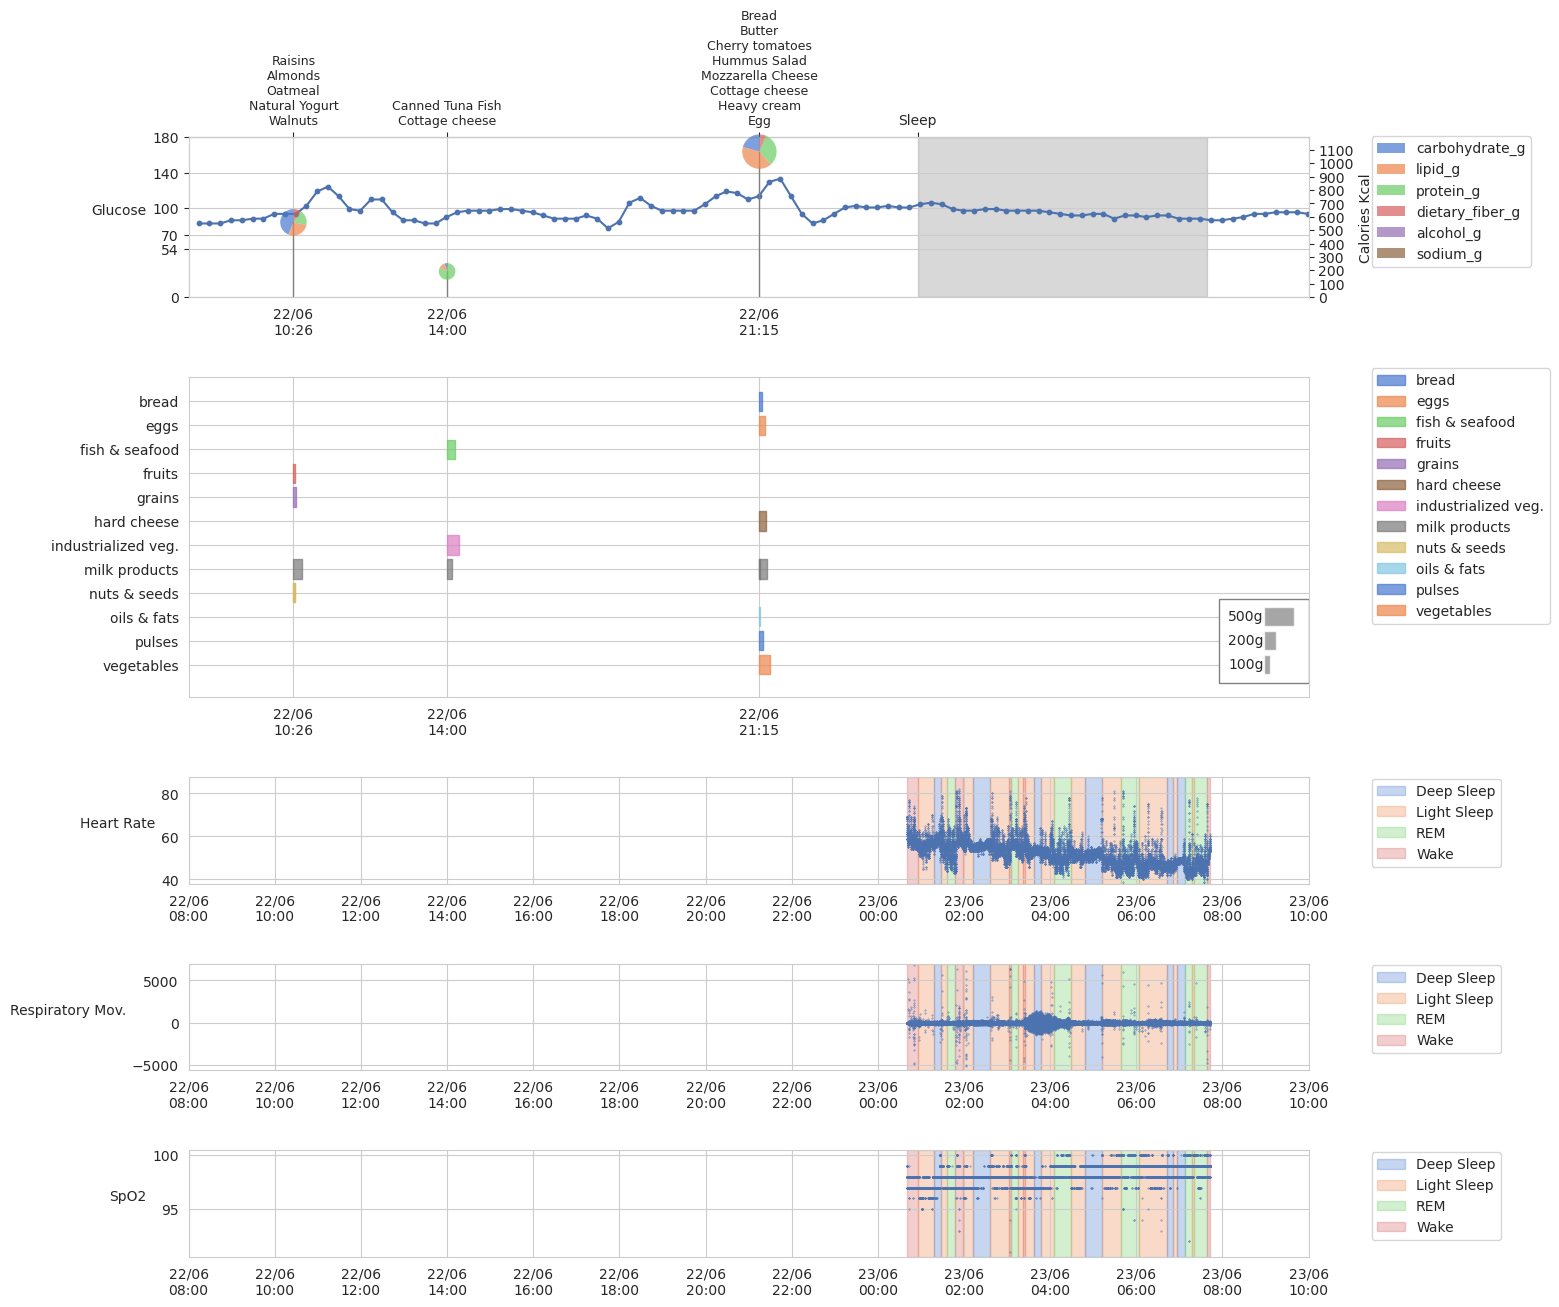

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')

plot_diet_cgm_sleep(diet_df, cgm_df, events_df, channels_df,
                    channel_filter=['heart_rate', 'respiratory_movement', 'spo2'],
                    time_range=('2020-06-22 08:00', '2020-06-23 10:00'))

Each of the types of diet plots can be plotted independently as well. We will use `TimeSeriesFigure`, `plot_nutrient_lollipop`, `plot_meals_hbars` and `plot_nutrient_bars` to plot them together.

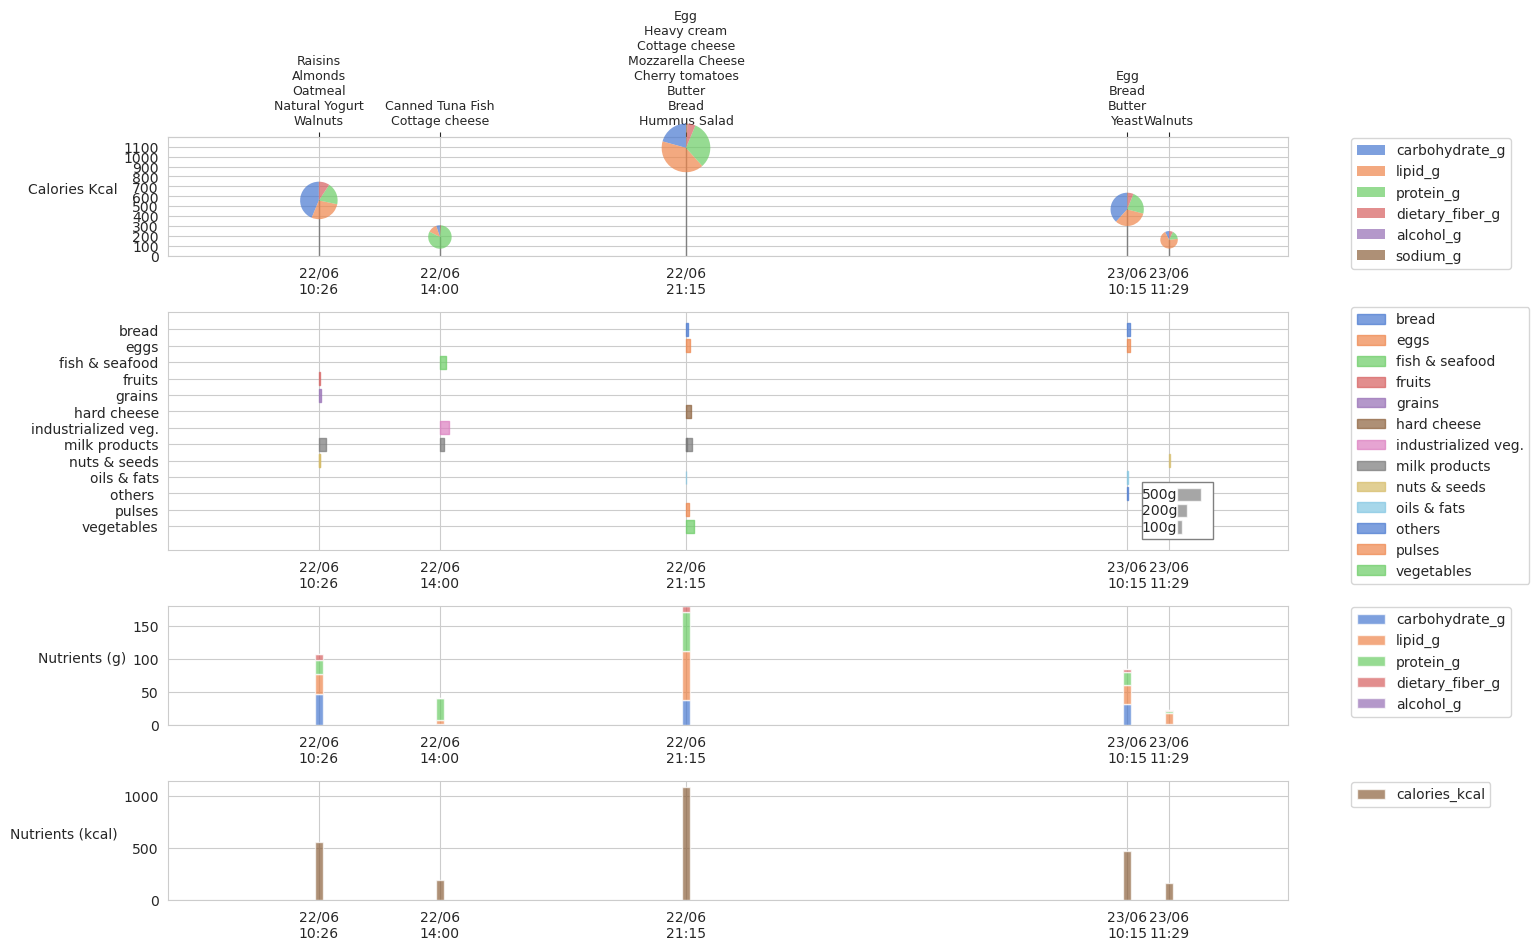

In [ ]:
from pheno_utils.timeseries_plots import TimeSeriesFigure

g = TimeSeriesFigure(figsize=(14, 7))

time_range = ('2020-06-22 06:00', '2020-06-23 15:00')
# Each call to the plot() methods adds a new time-synced subplot to the figure
g.plot(plot_nutrient_lollipop, diet_df, size_scale=15,
       time_range=time_range,
       name='diet_pie')
g.plot(plot_meals_hbars, diet_df,
       time_range=time_range,
       name='diet_meals', height=2)
g.plot(plot_nutrient_bars, diet_df,
       time_range=time_range,
       label=None, n_axes=2, nut_exclude=['sodium'],
       name='diet_bars')
g.set_axis_padding(0.03)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()